# Initializing

## Installing Libraries

In [1]:
!pip install google-cloud-storage
!pip install google-cloud-bigquery
!pip install google-cloud-bigquery-storage
!pip install datasets --user
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.7 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
ibis-framewor

## Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import os
import time
import subprocess
import re
import string
from google.colab import auth
from google.colab import drive
from google.cloud import bigquery
import seaborn as sns

from datasets import Dataset, DatasetDict

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

## Classes

In [3]:
##### Memory recorder ######

class Memory_recorder:
  def __init__(self):
    self.running = True  # Flag to control recording
    self.recording_thread = None  # Thread for background recording
    self.lowest_memory = None  # Store the lowest memory value
    self.filename = "memory_info.txt"  # File to store memory recordings
    self.total_memory = None

  def compile_recorder(self):
    with open("memory_recorder.cpp", "w") as f:
      f.write("""
      #include <iostream>
      #include <fstream>
      #include <sstream>
      #include <string>
      #include <regex>

      using namespace std;

      bool running = true;
      const int MAX_BUFFER_SIZE = 1024;
      char buffer[MAX_BUFFER_SIZE];

      string command = ("grep MemAvailable: /proc/meminfo");


      void read_memory_info(int lowest_memory) {
        ofstream outfile("memory_info.txt", ios::trunc);
        while (running) {
          FILE* process = popen(command.c_str(), "r");
          if (fgets(buffer, MAX_BUFFER_SIZE, process) != nullptr) {
            string line(buffer);
            std::regex regex(R"(\d+)");
            std::smatch match;
            while (std::regex_search(line, match, regex)) {
              int mem = std::stoi(match.str());
              if (mem < lowest_memory) {
                lowest_memory = mem;
                outfile.open("memory_info.txt");
                outfile << lowest_memory;
                outfile.close();
              }
              break;
            }
          }
          pclose(process);
        }
      }


      int main() {
        int lowest_memory = 999999999;
        running = true;
        read_memory_info(lowest_memory);
      }
      """)

    with open("total_memory.cpp", "w") as f:
      f.write("""
      #include <iostream>
      #include <fstream>
      #include <sstream>
      #include <string>
      #include <regex>

      using namespace std;


      const int MAX_BUFFER_SIZE = 1024;
      char buffer[MAX_BUFFER_SIZE];

      string command = ("grep MemTotal: /proc/meminfo");

      void total_memory() {
        FILE* process = popen(command.c_str(), "r");
        if (fgets(buffer, MAX_BUFFER_SIZE, process) != nullptr) {
          string line(buffer);
          std::regex regex(R"(\d+)");
          std::smatch match;
          while (std::regex_search(line, match, regex)) {
            int mem = std::stoi(match.str());
            cout << mem;
            break;
          }
        }
        pclose(process);
      }

      int main() {
        total_memory();
      }
      """)

    subprocess.run(["g++", "total_memory.cpp", "-o", "total_memory.exe"])
    subprocess.run(["g++", "memory_recorder.cpp", "-o", "memory_recorder.exe"])

    self.total_memory = subprocess.run('./total_memory.exe', shell = True, check = True, capture_output = True).stdout.decode('utf-8')
    self.total_memory = int(self.total_memory)
    os.remove('total_memory.cpp')
    os.remove('total_memory.exe')
    os.remove('memory_recorder.cpp')

  def record_in_background(self):
    while self.running:
      self.lowest_memory = subprocess.run('./memory_recorder.exe', shell = True, check = True, capture_output = True)

  def start_recording(self):
    # Create a thread to perform recording in the background
    self.lowest_memory = None  # Reset lowest_memory for each iteration
    self.running = True
    self.recording_thread = multiprocessing.Process(target = self.record_in_background)
    self.recording_thread.start()
    # print("Memory information recording started in the background.")

  def stop_recording(self):
    self.running = False
    self.recording_thread.terminate()
    subprocess.run('pkill -f memory_recorder.exe', shell = True)
    os.remove(self.filename)
    print("Memory information recording stopped.")

  def get_recording(self):
    # print("Memory information recording stopped.")
    self.recording_thread.terminate()
    while not os.path.isfile("memory_info.txt"):
      time.sleep(2)
    while os.path.isfile("memory_info.txt"):
      try:
        with open(self.filename, "r") as f:
          try:
            lines = f.readlines()[0]
          except:
            time.sleep(1)
            break
          self.lowest_memory = int(lines)
          if self.lowest_memory is None:
            break
          f.close()
          self.running = False
          subprocess.run('pkill -f memory_recorder.exe', shell = True)
          os.remove(self.filename)
          break
      except:
        continue

    peak = np.round((self.total_memory - self.lowest_memory)/(1024*1024), 2) # returns GBs
    return peak

  def kill(self):
    self.running = False
    try:
      self.recording_thread.terminate()
      print('Thread terminated.')
    except:
      print('No thread to terminate.')
    try:
      subprocess.run('pkill -f memory_recorder.exe', shell = True)
      print('Subprocess terminated.')
    except:
      print('No subprocess to terminate.')
    try:
      os.remove(self.filename)
      print(f'Removed: "{self.filename}"')
    except:
      print(f'Could not remove "{self.filename}"')
    # try:
    #   os.remove('total_memory.cpp')
    #   print('Removed: "total_memory.cpp"')
    # except:
    #   print('Could not remove "total_memory.cpp".')
    # try:
    #   os.remove('total_memory.exe')
    #   print('Removed: "total_memory.exe"')
    # except:
    #   print('Could not remove "total_memory.exe".')
    # try:
    #   os.remove('memory_recorder.cpp')
    #   print('Removed: "memory_recorder.cpp"')
    # except:
    #   print('Could not remove "memory_recorder.cpp".')
    try:
      os.remove('memory_recorder.exe')
      print('Removed: "memory_recorder.exe"')
    except:
      print('Could not remove "memory_recorder.exe".')



def timer_start():
  return time.time()

def timer_stop(start_time):
  return time.time() - start_time

### x_encoder_y ###
def x_encoder_y(the_x, the_y, features):

  if features != 'Text Only':
    the_x = the_x.fillna(0)

  x = the_x
  y = the_y
  le = LabelEncoder()
  le.fit(y)
  y = le.transform(y)

  return x, y

# Loading Data

In [4]:
auth.authenticate_user()

project_id = 'nlp-project-427710'
client = bigquery.Client(project = project_id)

datasets_names = list(client.list_datasets())
project = client.project
dataframe_names = []

for dataset in datasets_names:
  dataset_name = client.get_dataset(dataset.dataset_id)
  tables_names = list(client.list_tables(dataset_name))
  for table in tables_names:
    if table.table_id == 'c_botting':# or table.table_id[0:6] == 'c_prep' or table.table_id == 'c_sentiment':
      query = f"""
      SELECT *
      FROM {project_id}.{dataset.dataset_id}.{table.table_id}
      """
      df = client.query(query).to_dataframe()
      dataframe_names.append(table.table_id)
      globals()[table.table_id] = globals().pop('df')

print(dataframe_names)

['c_botting']


# Preprocessing

In [5]:
x = 'text'
y = 'label'


# c_prep_hate_speech1[y] = c_prep_hate_speech1['class']
# c_prep_hate_speech1.drop(columns = 'class', inplace = True)
#### c_prep_hate_speech1 = c_prep_hate_speech1[[x, y]]

c_botting[x] = c_botting['BoW']
c_botting[y] = c_botting['info_op']
c_botting = c_botting[[x, y]]

# c_sentiment[x] = c_sentiment['text']
# c_sentiment[y] = c_sentiment['target']
# c_sentiment = c_sentiment[[x, y]]

# hate_speech = c_prep_hate_speech1
# del c_prep_hate_speech1
# personality = c_prep_MBIT_personality
# del c_prep_MBIT_personality
# emotions = c_prep_emotions1
# del c_prep_emotions1
botting = c_botting
del c_botting
# sentiment = c_sentiment
# del c_sentiment

# dataframe_names_plus = ['hate_speech', 'personality', 'emotions']
# dataframe_names = ['botting', 'sentiment']

In [6]:
def join_splits(text):
  text = ''.join((text).split(' '))
  return text

botting['text'] = botting['text'].apply(join_splits)

puncs = string.punctuation
re_puncs = '[' + '\\'.join([punc for punc in puncs]) + ']'
compiled_puncs = re.compile(re_puncs)

def remove_puncs(text):
  return compiled_puncs.sub(' ', text)


botting['text'] = botting['text'].apply(remove_puncs)

def remove_whitespace(text):
  text = text.strip()
  return text

botting['text'] = botting['text'].apply(remove_whitespace)

def remove_whitespace2(text):
  if text == '':
    text = np.nan
    return text
  else:
    return text

botting['text'] = botting['text'].apply(remove_whitespace2)

botting[(botting['text'].isna())]['label'] = np.nan

botting.dropna(inplace = True)

print(botting['label'].value_counts())

label
0    1376847
1     607125
Name: count, dtype: Int64


<ipython-input-6-d25cf723c05b>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  botting[(botting['text'].isna())]['label'] = np.nan


# Running Models

In [ ]:
# 'bert-base-uncased'                               [0.772, 0.7632, 0.7626, 0.772]
# 'JungleLee/bert-toxic-comment-classification'     [0.7606, 0.7562, 0.7539, 0.7606]
# 'textattack/bert-base-uncased-yelp-polarity'      [0.7402, 0.7286, 0.7265, 0.7402]
# 'Intel/bert-base-uncased-mrpc'                    [0.7564, 0.752, 0.7496, 0.7564]
# 'mrm8488/bert-tiny-finetuned-sms-spam-detection'  [0.7304, 0.7231, 0.7197, 0.7304]
# 'google-bert/bert-base-cased'                     [0.744, 0.7329, 0.7309, 0.744]
# 'distilbert/distilbert-base-uncased-finetuned-sst-2-english'      [0.7462, 0.7399, 0.7371, 0.7462]

In [7]:
BERT_results_dict = {}

In [12]:
id = 0
tunning = 'Fine-Tune'
model_urls = ['distilbert/distilbert-base-uncased-finetuned-sst-2-english', 'bert-base-uncased', 'JungleLee/bert-toxic-comment-classification', 'Intel/bert-base-uncased-mrpc']
def tokenize_function(dataset):
    return tokenizer(dataset['text'], padding = 'max_length', truncation = True, max_length = 96, verbose = False)
data = botting

for model_url in model_urls:
  tokenizer = AutoTokenizer.from_pretrained(model_url)

  size = 100
  split = size/data.shape[0]

  x = data['text']
  y = data['label']

  start = timer_start()

  X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = 42, stratify = y, train_size = split, test_size = split/2)
  train_data = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis = 1)
  eval_data = pd.concat([pd.DataFrame(X_test), pd.DataFrame(y_test)], axis = 1)

  datasets_train_eval = DatasetDict({
      "train": Dataset.from_pandas(train_data),
      "test": Dataset.from_pandas(eval_data)
      })

  tokenized_datasets = datasets_train_eval.map(tokenize_function, batched=True)

  train_dataset = tokenized_datasets["train"]
  eval_dataset = tokenized_datasets["test"]


  model = AutoModelForSequenceClassification.from_pretrained(model_url, num_labels = 2)
  num_epochs = 10
  training_args = TrainingArguments("test_trainer", eval_strategy = "epoch", use_cpu = False, num_train_epochs = num_epochs)
  trainer = Trainer(model = model, args = training_args, train_dataset = train_dataset, eval_dataset = eval_dataset)


  trainer.train()

  X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = 421, stratify = y, train_size = split, test_size = split/2)
  test_data = pd.concat([pd.DataFrame(X_test), pd.DataFrame(y_test)], axis = 1)
  datasets_test = DatasetDict({
      "test": Dataset.from_pandas(test_data)
      })
  tokenized_datasets = datasets_test.map(tokenize_function, batched=True)
  test_dataset = tokenized_datasets["test"]

  predictions = trainer.predict(test_dataset)

  duration = timer_stop(start)

  pred = np.empty([1, 0], dtype=int)
  for i in range(predictions.predictions.shape[0]):
    pred = np.append(pred, predictions.predictions[i].argmax())

  results = []

  y_test = test_dataset['label']

  results.append(np.round(accuracy_score(y_test, pred), 4))
  results.append(np.round(f1_score(y_test, pred, average = 'weighted'), 4))
  results.append(np.round(precision_score(y_test, pred, average = 'weighted', zero_division = 0), 4))
  results.append(np.round(recall_score(y_test, pred, average = 'weighted'), 4))

  BERT_results_dict[id] = {
      'Model': model_url,
      'Tunning': tunning,
      'Training Size': size,
      'Duration (s)': np.round(duration, 1),
      'Accuracy Score': results[0],
      'F1 Score': results[1],
      'Precision Score': results[3],
      'Recall Score': results[2]
      }

  id += 1

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,No log,0.820044
2,No log,0.834432
3,No log,1.058285
4,No log,1.249530
5,No log,1.396088
6,No log,1.480407
7,No log,1.519227
8,No log,1.541671
9,No log,1.553817
10,No log,1.556641


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.599928
2,No log,0.547171
3,No log,0.619260
4,No log,0.776961
5,No log,1.136927
6,No log,1.223899
7,No log,1.622901
8,No log,1.566689
9,No log,1.571135
10,No log,1.574916


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,No log,0.630667
2,No log,0.722501
3,No log,0.755712
4,No log,1.289977
5,No log,1.543672
6,No log,1.727460
7,No log,1.780790
8,No log,1.800588
9,No log,1.808746
10,No log,1.812103


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,No log,0.598342
2,No log,0.724039
3,No log,0.890624
4,No log,1.814346
5,No log,1.504216
6,No log,2.430192
7,No log,2.183083
8,No log,2.009977
9,No log,2.030352
10,No log,2.039244


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [13]:
BERT_results_dict

{0: {'Model': 'distilbert/distilbert-base-uncased-finetuned-sst-2-english',
  'Tunning': 'Fine-Tune',
  'Training Size': 100,
  'Duration (s)': 14.7,
  'Accuracy Score': 0.78,
  'F1 Score': 0.7653,
  'Precision Score': 0.78,
  'Recall Score': 0.77},
 1: {'Model': 'bert-base-uncased',
  'Tunning': 'Fine-Tune',
  'Training Size': 100,
  'Duration (s)': 27.1,
  'Accuracy Score': 0.74,
  'F1 Score': 0.6824,
  'Precision Score': 0.74,
  'Recall Score': 0.7424},
 2: {'Model': 'JungleLee/bert-toxic-comment-classification',
  'Tunning': 'Fine-Tune',
  'Training Size': 100,
  'Duration (s)': 27.2,
  'Accuracy Score': 0.72,
  'F1 Score': 0.6675,
  'Precision Score': 0.72,
  'Recall Score': 0.6933},
 3: {'Model': 'Intel/bert-base-uncased-mrpc',
  'Tunning': 'Fine-Tune',
  'Training Size': 100,
  'Duration (s)': 27.1,
  'Accuracy Score': 0.66,
  'F1 Score': 0.6481,
  'Precision Score': 0.66,
  'Recall Score': 0.6408}}

In [14]:
tunning = 'No Fine-Tune'
model_urls = ['distilbert/distilbert-base-uncased-finetuned-sst-2-english', 'bert-base-uncased', 'JungleLee/bert-toxic-comment-classification', 'Intel/bert-base-uncased-mrpc']
def tokenize_function(dataset):
    return tokenizer(dataset['text'], padding = 'max_length', truncation = True, max_length = 96, verbose = False)
data = botting

for model_url in model_urls:
  tokenizer = AutoTokenizer.from_pretrained(model_url)

  size = 100
  split = size/data.shape[0]

  x = data['text']
  y = data['label']

  start = timer_start()

  X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = 42, stratify = y, train_size = split, test_size = split/2)
  train_data = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis = 1)
  eval_data = pd.concat([pd.DataFrame(X_test), pd.DataFrame(y_test)], axis = 1)

  datasets_train_eval = DatasetDict({
      "train": Dataset.from_pandas(train_data),
      "test": Dataset.from_pandas(eval_data)
      })

  tokenized_datasets = datasets_train_eval.map(tokenize_function, batched=True)

  train_dataset = tokenized_datasets["train"]
  eval_dataset = tokenized_datasets["test"]


  model = AutoModelForSequenceClassification.from_pretrained(model_url, num_labels = 2)
  num_epochs = 1
  training_args = TrainingArguments("test_trainer", eval_strategy = "epoch", use_cpu = False, num_train_epochs = num_epochs)
  trainer = Trainer(model = model, args = training_args, train_dataset = train_dataset, eval_dataset = eval_dataset)



  # trainer.train()

  X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = 421, stratify = y, train_size = split, test_size = split/2)
  test_data = pd.concat([pd.DataFrame(X_test), pd.DataFrame(y_test)], axis = 1)
  datasets_test = DatasetDict({
      "test": Dataset.from_pandas(test_data)
      })
  tokenized_datasets = datasets_test.map(tokenize_function, batched=True)
  test_dataset = tokenized_datasets["test"]

  predictions = trainer.predict(test_dataset)

  duration = timer_stop(start)

  pred = np.empty([1, 0], dtype=int)
  for i in range(predictions.predictions.shape[0]):
    pred = np.append(pred, predictions.predictions[i].argmax())

  results = []

  y_test = test_dataset['label']

  results.append(np.round(accuracy_score(y_test, pred), 4))
  results.append(np.round(f1_score(y_test, pred, average = 'weighted'), 4))
  results.append(np.round(precision_score(y_test, pred, average = 'weighted', zero_division = 0), 4))
  results.append(np.round(recall_score(y_test, pred, average = 'weighted'), 4))

  BERT_results_dict[id] = {
      'Model': model_url,
      'Tunning': tunning,
      'Training Size': size,
      'Duration (s)': np.round(duration, 1),
      'Accuracy Score': results[0],
      'F1 Score': results[1],
      'Precision Score': results[3],
      'Recall Score': results[2]
      }

  id += 1

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

# Results

In [15]:
BERT_results = pd.DataFrame([])
for i in BERT_results_dict.keys():
  BERT_results = pd.concat([BERT_results, pd.json_normalize(BERT_results_dict[i])])

In [16]:
BERT_results

,Model,Tunning,Training Size,Duration (s),Accuracy Score,F1 Score,Precision Score,Recall Score
0,distilbert/distilbert-base-uncased-finetuned-s...,Fine-Tune,100,14.7,0.78,0.7653,0.78,0.7700
0,bert-base-uncased,Fine-Tune,100,27.1,0.74,0.6824,0.74,0.7424
0,JungleLee/bert-toxic-comment-classification,Fine-Tune,100,27.2,0.72,0.6675,0.72,0.6933
0,Intel/bert-base-uncased-mrpc,Fine-Tune,100,27.1,0.66,0.6481,0.66,0.6408
0,distilbert/distilbert-base-uncased-finetuned-s...,No Fine-Tune,100,0.9,0.58,0.5757,0.58,0.5718
0,bert-base-uncased,No Fine-Tune,100,1.2,0.70,0.5765,0.70,0.4900
0,JungleLee/bert-toxic-comment-classification,No Fine-Tune,100,1.5,0.64,0.6092,0.64,0.5951
0,Intel/bert-base-uncased-mrpc,No Fine-Tune,100,1.5,0.70,0.5765,0.70,0.4900


In [22]:
BERT_results.groupby('Tunning')['Precision Score'].mean()

Tunning
Fine-Tune       0.725
No Fine-Tune    0.655
Name: Precision Score, dtype: float64

<Axes: xlabel='Tunning', ylabel='Precision Score'>

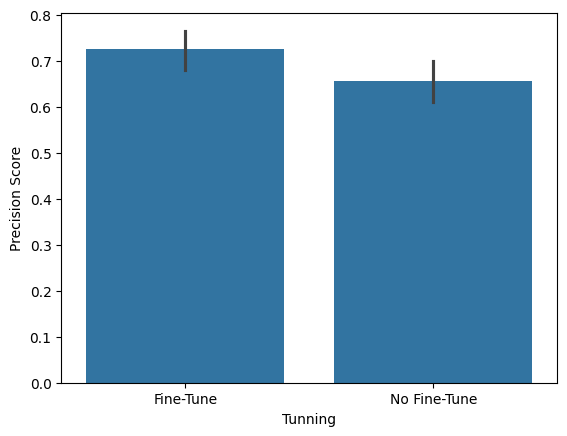

In [26]:
sns.barplot(x = 'Tunning', y = 'Precision Score', data = BERT_results)

In [23]:
BERT_results.groupby('Tunning')['Duration (s)'].mean()

Tunning
Fine-Tune       24.025
No Fine-Tune     1.275
Name: Duration (s), dtype: float64

<Axes: xlabel='Tunning', ylabel='Duration (s)'>

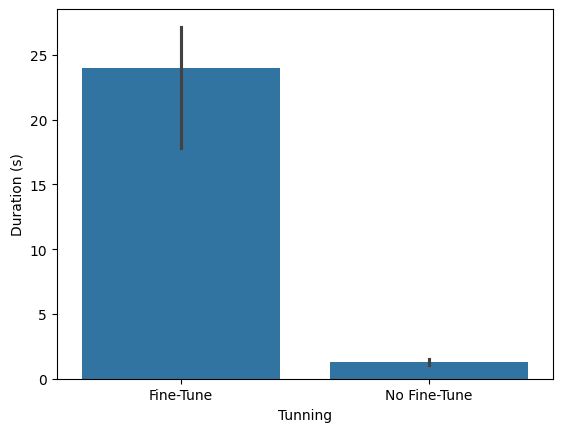

In [27]:
sns.barplot(x = 'Tunning', y = 'Duration (s)', data = BERT_results)